# Motion Artefact Detection and Correction
This notebook shows how to identify and correct motion-artefacts using xarray-based masks and cedalion's correction functionality. 

In [2]:
import matplotlib.pyplot as p

import cedalion
import cedalion.datasets as datasets
import cedalion.nirs
import cedalion.sigproc.motion_correct as motion_correct
import cedalion.sigproc.quality as quality
import cedalion.sim.synthetic_artifact as synthetic_artifact
from cedalion import units
import numpy as np
np.float_ = np.float64

Magnitude,[[[0.04182104534463356 0.047746797329110455 0.05050950973106057 ... 0.08227263374411163 0.083286873587128 0.07824392150574937] [0.025627508459706377 0.024137092419595378 0.0429305595224361 ... 0.11612429423314254 0.11917231885806306 0.12386443752963375]] [[-0.007153762115272221 -0.015313411855494478 0.0028633292508715344 ... 0.0538330121011891 0.05068234364887062 0.05268067206385335] [-0.03581862586715296 -0.03744384531404913 -0.021801923145000946 ... 0.08155007937072742 0.07904583462355086 0.07842621089251861]] [[0.10183836647552824 0.10201916945983605 0.1169437359769793 ... 0.036961549209740166 0.042025789997777216 0.04167813894134523] [0.05150480430462284 0.05107216528400333 0.06720500206431394 ... 0.07442830057234531 0.07835364164721434 0.07515144477286897]] ... [[0.09673332812319535 0.11390596415162903 0.11268753650827586 ... 0.027641865641862877 0.030579662689616594 0.02245210556417454] [0.040438060991082846 0.06703889060720171 0.06963290955139603 ... 0.10304278234751162 0.1024030367939344 0.09205353693419036]] [[0.15625526247177746 0.1748172251307937 0.17415338895402785 ... -0.00790466350172839 -0.007737031806504233 -0.01269059300393913] [0.10421169045923356 0.1300076194002813 0.1338818222776103 ... 0.04663763064379419 0.04687754203043111 0.039742773155083504]] [[0.0584091468171385 0.062051294085980604 0.06243476337739011 ... -0.0010106205738669438 -0.0008559972820785314 -0.002196738744364494] [0.02485457405467798 0.03195964163588069 0.03433688307775319 ... 0.013262516332383439 0.013411948619604765 0.011181193988526595]]]
Units,dimensionless


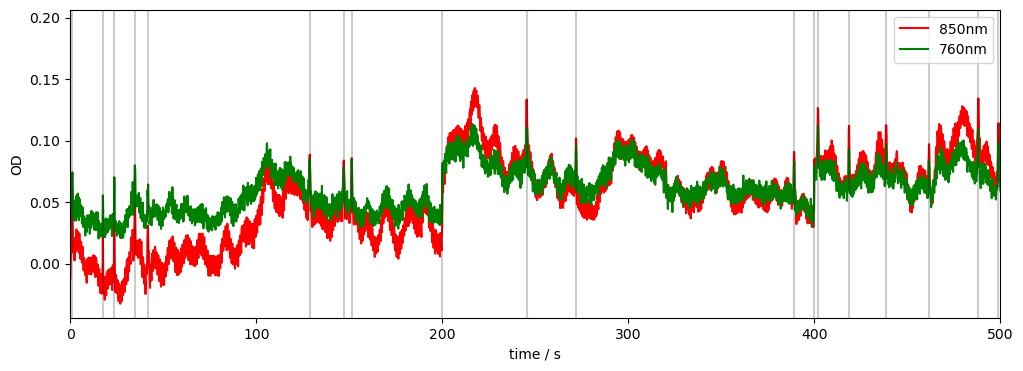

In [3]:
# get example finger tapping dataset

rec = datasets.get_fingertapping()
rec["od"] = cedalion.nirs.int2od(rec["amp"])

# Add some synthetic spikes and baseline shifts
artifacts = {
    "spike": synthetic_artifact.gen_spike,
    "bl_shift": synthetic_artifact.gen_bl_shift,
}
timing = synthetic_artifact.random_events_perc(rec["od"].time, 0.01, ["spike"])
timing = synthetic_artifact.add_event_timing(
    [(200, 0), (400, 0)], "bl_shift", None, timing
)
rec["od"] = synthetic_artifact.add_artifacts(rec["od"], timing, artifacts)

# Plot some data for visual validation
f, ax = p.subplots(1, 1, figsize=(12, 4))
ax.plot(
    rec["od"].time, rec["od"].sel(channel="S3D3", wavelength="850"), "r-", label="850nm"
)
ax.plot(
    rec["od"].time, rec["od"].sel(channel="S3D3", wavelength="760"), "g-", label="760nm"
)

# indicate added artefacts
for _,row in timing.iterrows():
    p.axvline(row["onset"], c="k", alpha=.2)

p.legend()
ax.set_xlim(0, 500)
ax.set_xlabel("time / s")
ax.set_ylabel("OD")


display(rec["od"])

In [4]:
display(timing)

,onset,duration,trial_type,value,channel
0,967.197112,0.300222,spike,1,None
1,1393.705112,0.338599,spike,1,None
2,2522.611010,0.360815,spike,1,None
3,1694.990475,0.175047,spike,1,None
4,1301.861867,0.260272,spike,1,None
...,...,...,...,...,...
112,418.654478,0.213432,spike,1,None
113,1122.171918,0.275263,spike,1,None
114,1367.239120,0.203923,spike,1,None
115,200.000000,0.000000,bl_shift,1,None


## Detecting Motion Artifacts and generating the MA mask
The example below shows how to check channels for motion artefacts using standard thresholds from Homer2/3. 
The output is a mask that can be handed to motion correction algorithms that require segments flagged as artefact.

In [5]:
# we use Optical Density data for motion artifact detection
fnirs_data = rec["od"]

# define parameters for motion artifact detection. We follow the method from Homer2/3:
# "hmrR_MotionArtifactByChannel" and "hmrR_MotionArtifact".
t_motion = 0.5 * units.s  # time window for motion artifact detection
t_mask = 1.0 * units.s    # time window for masking motion artifacts
                          # (+- t_mask s before/after detected motion artifact)
stdev_thresh = 7.0        # threshold for std. deviation of the signal used to detect
                          # motion artifacts. Default is 50. We set it very low to find
                          # something in our good data for demonstration purposes.
amp_thresh = 5.0          # threshold for amplitude of the signal used to detect motion
                          # artifacts. Default is 5.

# to identify motion artifacts with these parameters we call the following function
ma_mask = quality.id_motion(fnirs_data, t_motion, t_mask, stdev_thresh, amp_thresh)

# it hands us a boolean mask (xarray) of the input dimension, where False indicates a
# motion artifact at a given time point:
ma_mask

<xarray.DataArray (channel: 28, wavelength: 2, time: 23239)> Size: 1MB
array([[[ True,  True,  True, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       ...,

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]]],
      shape=(28, 2, 23239))
Coordinates:
  * time        (time) float64 186kB 0.0 0.128 0.256 ... 2.974e+03 2.974e+03
    samples     (time) int64 186kB 0 1 2 3 4 5 ... 23234 23235 23236 23237 23238
  * channel     (channel) object 224B 'S1D1' 'S1D2' 'S1D3' ... 'S8D8' 'S8D16'
    source      (channel) object 224B 'S1' 'S1' 'S1' 'S1' ... 'S8' 'S8' 'S8'
    detector    (channel) object 224B 'D1' 'D2' 'D3' 'D9' ... 'D7' 'D8' 'D16'
  * wavelength  (wavelength) float64 16B 760.0 850.0

The output mask is quite detailed and still contains all original dimensions (e.g. single wavelengths) and allows us to combine it with a mask from another motion artifact detection method. This is the same approach as for the channel quality metrics above.

Let us now plot the result for an example channel. Note, that for both wavelengths a different number of artifacts was identified, which can sometimes happen:

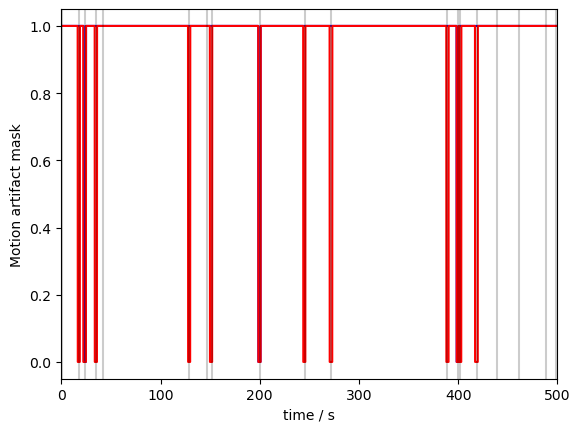

In [6]:
p.figure()
p.plot(ma_mask.time, ma_mask.sel(channel="S3D3", wavelength="760"), "b-")
p.plot(ma_mask.time, ma_mask.sel(channel="S3D3", wavelength="850"), "r-")

# indicate added artefacts
for _,row in timing.iterrows():
    p.axvline(row["onset"], c="k", alpha=.2)

p.xlim(0, 500)
p.xlabel("time / s")
p.ylabel("Motion artifact mask")


p.show()

Plotting the mask and the data together (we have to rescale a bit to make both fit): 

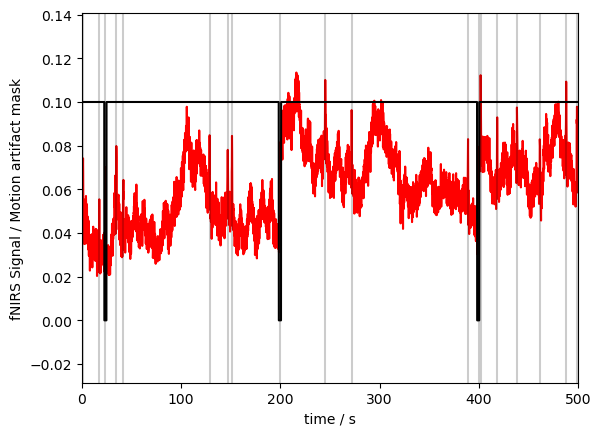

In [7]:
p.figure()
p.plot(fnirs_data.time, fnirs_data.sel(channel="S3D3", wavelength="760"), "r-")
p.plot(ma_mask.time, ma_mask.sel(channel="S3D3", wavelength="760") / 10, "k-")

# indicate added artefacts
for _,row in timing.iterrows():
    p.axvline(row["onset"], c="k", alpha=.2)

p.xlim(0, 500)
p.xlabel("time / s")
p.ylabel("fNIRS Signal / Motion artifact mask")
p.show()


### Refining the MA Mask
At the latest when we want to correct motion artifacts, we usually do not need the level of granularity that the mask provides. For instance, we usually want to treat a detected motion artifact in either of both wavelengths or chromophores of one channel as a single artifact that gets flagged for both. We might also want to flag motion artifacts globally, i.e. mask time points for all channels even if only some of them show an artifact. This can easily be done by using the "id_motion_refine" function. The function also returns useful information about motion artifacts in each channel in "ma_info"

In [8]:
# refine the motion artifact mask. This function collapses the mask along dimensions
# that are chosen by the "operator" argument. Here we use "by_channel", which will yield
# a mask for each channel by collapsing the masks along either the wavelength or
# concentration dimension.
ma_mask_refined, ma_info = quality.id_motion_refine(ma_mask, "by_channel")

# show the refined mask
ma_mask_refined

<xarray.DataArray (channel: 28, time: 23239)> Size: 651kB
array([[False, False, False, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]], shape=(28, 23239))
Coordinates:
  * time      (time) float64 186kB 0.0 0.128 0.256 ... 2.974e+03 2.974e+03
    samples   (time) int64 186kB 0 1 2 3 4 5 ... 23234 23235 23236 23237 23238
  * channel   (channel) object 224B 'S1D1' 'S1D2' 'S1D3' ... 'S8D8' 'S8D16'
    source    (channel) object 224B 'S1' 'S1' 'S1' 'S1' ... 'S7' 'S8' 'S8' 'S8'
    detector  (channel) object 224B 'D1' 'D2' 'D3' 'D9' ... 'D7' 'D8' 'D16'

Now the mask does not have the "wavelength" or "concentration" dimension anymore, and the masks of these dimensions are combined:

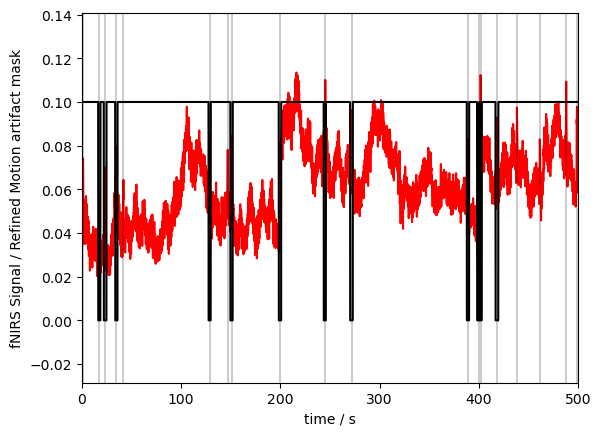

,channel,ma_fraction,ma_count
0,S1D1,0.085675,96
1,S1D2,0.055338,65
2,S1D3,0.053143,64
3,S1D9,0.041396,50
4,S2D1,0.043763,55
5,S2D3,0.061405,72
6,S2D4,0.023538,26
7,S2D10,0.064375,75
8,S3D2,0.032661,42
9,S3D3,0.057231,69


In [9]:
# plot the figure
p.figure()
p.plot(fnirs_data.time, fnirs_data.sel(channel="S3D3", wavelength="760"), "r-")
p.plot(ma_mask_refined.time, ma_mask_refined.sel(channel="S3D3") / 10, "k-")

# indicate added artefacts
for _,row in timing.iterrows():
    p.axvline(row["onset"], c="k", alpha=.2)

p.xlim(0, 500)
p.xlabel("time / s")
p.ylabel("fNIRS Signal / Refined Motion artifact mask")
p.show()

# show the information about the motion artifacts: we get a pandas dataframe telling us
# 1) for which channels artifacts were detected,
# 2) what is the fraction of time points that were marked as artifacts and
# 3) how many artifacts where detected
ma_info


Now we look at the "all" operator, which will collapse the mask across all dimensions except time, leading to a single motion artifact mask

In [10]:
# "all", yields a mask that flags an artifact at any given time if flagged for
# any channetransl, wavelength, chromophore, etc.
ma_mask_refined, ma_info = quality.id_motion_refine(ma_mask, 'all')

# show the refined mask
ma_mask_refined

<xarray.DataArray (time: 23239)> Size: 23kB
array([False, False, False, ...,  True,  True,  True], shape=(23239,))
Coordinates:
  * time     (time) float64 186kB 0.0 0.128 0.256 ... 2.974e+03 2.974e+03
    samples  (time) int64 186kB 0 1 2 3 4 5 ... 23234 23235 23236 23237 23238

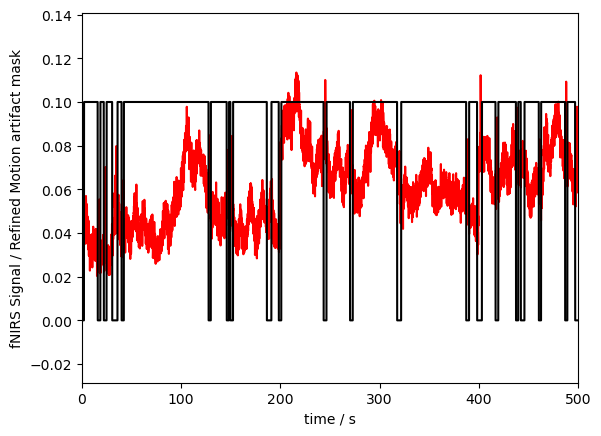

,channel,ma_fraction,ma_count
0,all channels combined,"[0.9992684711046086, 0.9968587288609665]","[1, 4]"


In [11]:
# plot the figure
p.figure()
p.plot(fnirs_data.time, fnirs_data.sel(channel="S3D3", wavelength="760"), "r-")
p.plot(ma_mask_refined.time, ma_mask_refined/10, "k-")
p.xlim(0,500)
p.xlabel("time / s")
p.ylabel("fNIRS Signal / Refined Motion artifact mask")
p.show()

# show the information about the motion artifacts: we get a pandas dataframe telling us
# 1) that the mask is for all channels
# 2) fraction of time points that were marked as artifacts for this mask across all
#    channels
# 3) how many artifacts where detected in total
ma_info

## Motion Correction

Here we illustrate effect of different motion correction methods. Cedalion might have more methods, so make sure to check the API documentation. 

In [12]:
def compare_raw_cleaned(rec, key_raw, key_cleaned, title):
    chwl = dict(channel="S3D3", wavelength="850")
    f, ax = p.subplots(1, 1, figsize=(12, 4))
    ax.plot(
        rec[key_raw].time,
        rec[key_raw].sel(**chwl),
        "r-",
        label="850nm raw",
    )
    ax.plot(
        rec[key_cleaned].time,
        rec[key_cleaned].sel(**chwl),
        "g-",
        label="850nm cleaned",
    )
    ax.set_xlim(0, 500)
    ax.set_ylabel("OD")
    ax.set_xlabel("time / s")
    ax.set_title(title)
    ax.legend()

    # indicate added artefacts
    for _,row in timing.iterrows():
        p.axvline(row["onset"], c="k", alpha=.2)


### SplineSG method: 
1. identifies baselineshifts in the data and uses spline interpolation to correct these shifts
2. uses a Savitzky-Golay filter to remove spikes

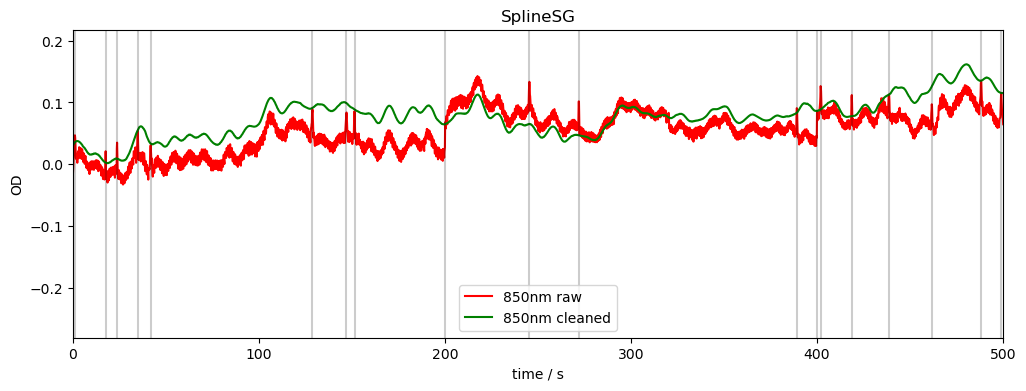

In [13]:
frame_size = 10 * units.s
rec["od_splineSG"] = motion_correct.motion_correct_splineSG(
    rec["od"], frame_size=frame_size, p=1
)

compare_raw_cleaned(rec, "od", "od_splineSG", "SplineSG")


### TDDR:

- Temporal Derivative Distribution Repair (TDDR) is a robust regression based motion correction algorithm.
- Doesn't require any user-supplied parameters
- See <cite data-cite="Fishburn2019">(Fishburn, 2019)</cite>

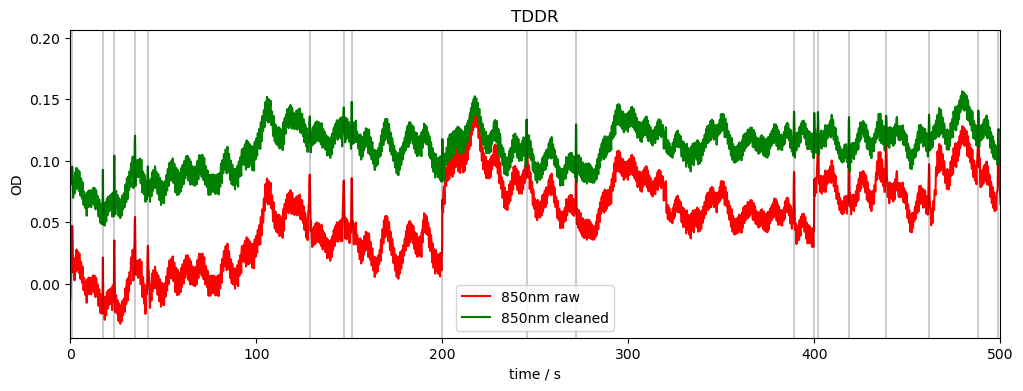

In [14]:
rec["od_tddr"] = motion_correct.tddr(rec["od"])

compare_raw_cleaned(rec, "od", "od_tddr", "TDDR")

### PCA

- Apply motion correction using PCA filter on motion artefact segments (identified by mask).
- Implementation is based on Homer3 v1.80.2 "hmrR_MotionCorrectPCA.m"

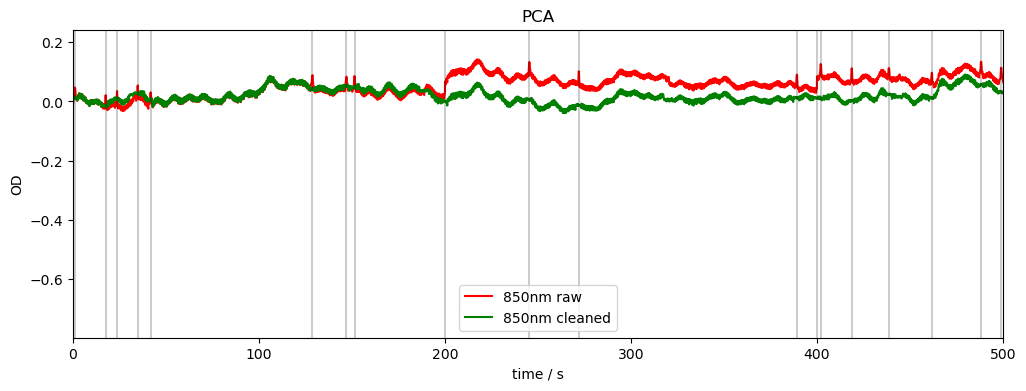

In [15]:
rec["od_pca"], nSV_ret, svs = motion_correct.motion_correct_PCA(
    rec["od"], ma_mask_refined
)

compare_raw_cleaned(rec, "od", "od_pca", "PCA")

### Recursive PCA

- If any active channel exhibits signal change greater than STDEVthresh or AMPthresh, then that segment of data is marked as a motion artefact. 
- motion_correct_PCA is applied to all segments of data identified as a motion artefact.
- This is called until maxIter is reached or there are no motion artefacts identified.

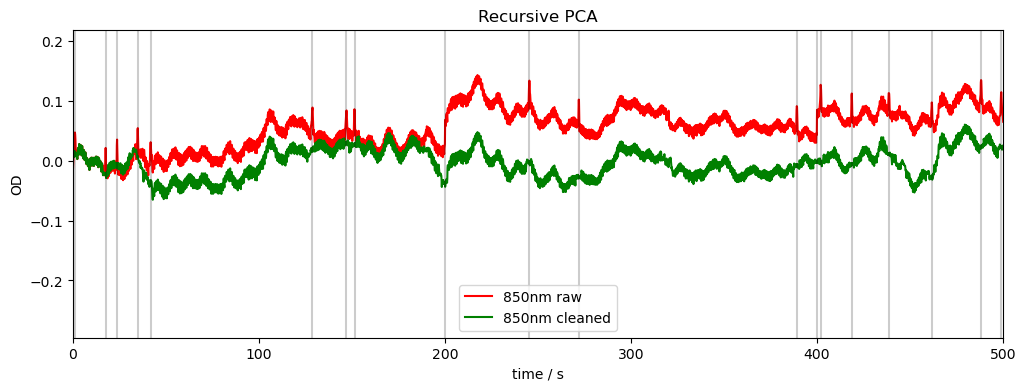

In [16]:
rec["od_pca_r"], svs, nSV, tInc = motion_correct.motion_correct_PCA_recurse(
    rec["od"], t_motion, t_mask, stdev_thresh, amp_thresh
)

compare_raw_cleaned(rec, "od", "od_pca_r", "Recursive PCA")

### Wavelet Motion Correction

- Focused on spike artifacts
- Can set iqr factor, wavelet, and wavelet decomposition level.
- Higher iqr factor leads to more coefficients being discarded, i.e. more drastic correction.


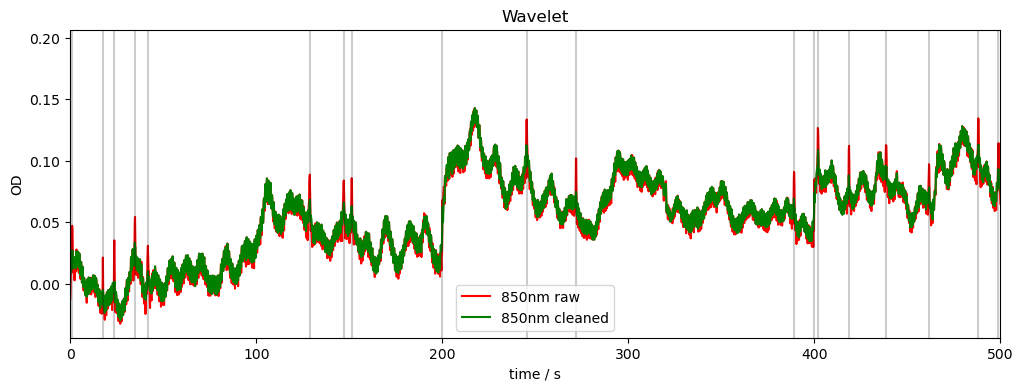

In [17]:
rec["od_wavelet"] = motion_correct.motion_correct_wavelet(rec["od"])

compare_raw_cleaned(rec, "od", "od_wavelet", "Wavelet")